In [26]:
import os
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

In [27]:
def get_record_list(data_dir):
    """
    Read the RECORDS file to get the list of record numbers.
    
    Parameters:
    data_dir (str): Path to the directory containing the MIT-BIH database files
    
    Returns:
    list: List of record numbers as strings
    """
    records_file = os.path.join(data_dir, 'RECORDS')
    with open(records_file, 'r') as f:
        return [line.strip() for line in f]

def load_mit_bih_records(data_dir):
    """
    Load all MIT-BIH Arrhythmia Database records and annotations from the specified directory.
    
    Parameters:
    data_dir (str): Path to the directory containing the MIT-BIH database files
    
    Returns:
    dict: Dictionary containing record information, signals, and annotations
    """
    # Get record numbers from RECORDS file
    record_numbers = get_record_list(data_dir)
    
    # Dictionary to store all records
    database = {
        'records': {},
        'metadata': {
            'sampling_frequency': None,
            'total_records': 0,
            'signal_length': None
        }
    }
    
    # Load each record
    for record_name in tqdm(record_numbers, desc="Loading ECG records"):
        record_path = os.path.join(data_dir, record_name)
        
        try:
            # Read the record
            record = wfdb.rdrecord(record_path)
            
            # Read the annotations
            try:
                ann = wfdb.rdann(record_path, 'atr')
                annotations = {
                    'sample': ann.sample,
                    'symbol': ann.symbol,
                    'subtype': ann.subtype,
                    'chan': ann.chan,
                    'num': ann.num,
                    'aux_note': ann.aux_note,
                    'fs': ann.fs
                }
                
                # Calculate annotation statistics
                symbol_counts = Counter(ann.symbol)
                
            except Exception as e:
                print(f"Error loading annotations for record {record_name}: {str(e)}")
                annotations = None
                symbol_counts = None
            
            # Store record information
            database['records'][record_name] = {
                'signals': record.p_signal,
                'channels': record.sig_name,
                'units': record.units,
                'fs': record.fs,
                'baseline': record.baseline,
                'comments': record.comments,
                'annotations': annotations,
                'annotation_counts': symbol_counts
            }
            
            # Update metadata
            if database['metadata']['sampling_frequency'] is None:
                database['metadata']['sampling_frequency'] = record.fs
            if database['metadata']['signal_length'] is None:
                database['metadata']['signal_length'] = len(record.p_signal)
            database['metadata']['total_records'] += 1
            
        except Exception as e:
            print(f"Error loading record {record_name}: {str(e)}")
            continue
    
    return database

data_dir = 'src/data/mit-bih-arrhythmia-database-1.0.0'
database = load_mit_bih_records(data_dir)
print(f"\nLoaded {database['metadata']['total_records']} records from RECORDS file")

Loading ECG records: 100%|██████████| 48/48 [00:01<00:00, 37.83it/s]



Loaded 48 records from RECORDS file


In [28]:
def get_record_summary(database):
    """Generate a summary of loaded records with annotation statistics."""
    summaries = []

    for record_name, record_data in database['records'].items():
        signals, annotations = record_data['signals'], record_data['annotations']
        summary = {
            'record_name': record_name,
            'duration_seconds': len(signals) / record_data['fs'],
            'num_channels': signals.shape[1],
            'fs': record_data['fs'],
            'total_annotations': len(annotations['sample']) if annotations else 0
        }

        # Channel statistics
        for i in range(signals.shape[1]):
            summary.update({f'mean_ch{i + 1}': np.mean(signals[:, i]), f'std_ch{i + 1}': np.std(signals[:, i])})

        # Annotation counts
        if record_data['annotation_counts']:
            summary.update({f'annotation_{sym}': cnt for sym, cnt in record_data['annotation_counts'].items()})

        summaries.append(summary)

    return pd.DataFrame(summaries)

def get_annotations_as_dataframe(record_data):
    """Convert record annotations to a pandas DataFrame."""
    if not record_data['annotations']:
        return None

    ann = record_data['annotations']
    return pd.DataFrame({
        'sample': ann['sample'],
        'time': ann['sample'] / ann['fs'],
        'symbol': ann['symbol'],
        'subtype': ann['subtype'],
        'channel': ann['chan'],
        'aux_note': ann['aux_note']
    })

def get_global_annotation_counts(database):
    """Calculate global counts of annotation symbols."""
    global_counts = Counter()

    for record_data in database['records'].values():
        global_counts.update(record_data.get('annotation_counts', {}))

    total = sum(global_counts.values())
    return pd.DataFrame([
        {'symbol': sym, 'count': cnt, 'percentage': round(cnt / total * 100, 2), 'description': get_symbol_description(sym)}
        for sym, cnt in global_counts.most_common()
    ])

def get_symbol_description(symbol):
    """Return the description of an annotation symbol."""
    descriptions = {
        'N': 'Normal beat', 'L': 'Left bundle branch block', 'R': 'Right bundle branch block',
        'A': 'Atrial premature beat', 'V': 'Premature ventricular contraction', '/': 'Paced beat',
        'Q': 'Unclassifiable beat', '+': 'Rhythm change', '~': 'Signal quality change'
    }
    return descriptions.get(symbol, 'Unknown annotation')

# Display global annotation statistics
print("\nGlobal Annotation Statistics:")
annotation_stats = get_global_annotation_counts(database)
pd.set_option('display.max_rows', None)
print(annotation_stats.to_string(index=False))



Global Annotation Statistics:
symbol  count  percentage                       description
     N  75052       66.63                       Normal beat
     L   8075        7.17          Left bundle branch block
     R   7259        6.44         Right bundle branch block
     V   7130        6.33 Premature ventricular contraction
     /   7028        6.24                        Paced beat
     A   2546        2.26             Atrial premature beat
     +   1291        1.15                     Rhythm change
     f    982        0.87                Unknown annotation
     F    803        0.71                Unknown annotation
     ~    616        0.55             Signal quality change
     !    472        0.42                Unknown annotation
     "    437        0.39                Unknown annotation
     j    229        0.20                Unknown annotation
     x    193        0.17                Unknown annotation
     a    150        0.13                Unknown annotation
     |   

In [29]:
class ECGDataset(Dataset):
    def __init__(self, samples, labels):
        self.samples = samples
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(labels)
        
        # Print distribution (only for initial dataset, not upsampled)
        label_counts = Counter(self.labels)
        print("\nDataset label distribution:")
        for label_idx, count in label_counts.items():
            label_name = self.label_encoder.inverse_transform([label_idx])[0]
            print(f"Label {label_name}: {count} samples")
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        sample = torch.FloatTensor(self.samples[idx])
        label = torch.LongTensor([self.labels[idx]])[0]
        return sample.unsqueeze(0), label
    
def prepare_data(data_dir):
    """Prepare ECG datasets with upsampling of 'A' and 'V' labels."""
    
    REMOVE_LABELS = {'+', '~', '"', '[', ']', '|'}
    all_samples = []
    all_labels = []
    
    # Read RECORDS file for all available patient recordings
    with open(os.path.join(data_dir, 'RECORDS'), 'r') as f:
        record_numbers = [line.strip() for line in f]

    label_counter = Counter()
    
    # Count occurrences of each label
    for record_num in tqdm(record_numbers, desc="Counting labels"):
        record_path = os.path.join(data_dir, str(record_num))
        try:
            annotations = wfdb.rdann(record_path, 'atr')
            label_counter.update(annotations.symbol)
        except:
            continue

    # Remove unwanted labels and calculate the 1% threshold
    total_beats = sum(label_counter.values())
    min_threshold = total_beats * 0.01  # 1% threshold

    valid_labels = {label for label, count in label_counter.items() if count >= min_threshold and label not in REMOVE_LABELS}
    print(f"Selected Labels (≥1% frequency): {valid_labels}")

    # Process data and extract spectrograms
    for record_num in tqdm(record_numbers, desc="Processing data"):
        record_path = os.path.join(data_dir, str(record_num))
        try:
            record = wfdb.rdrecord(record_path)
            annotations = wfdb.rdann(record_path, 'atr')
            signal_data = record.p_signal[:, 0]
            
            frequencies, times, Sxx = signal.spectrogram(signal_data, fs=record.fs, window='hann',
                                                         nperseg=1024, noverlap=512, detrend='constant')
            
            Sxx = np.log1p(Sxx)
            Sxx = (Sxx - Sxx.mean()) / (Sxx.std() + 1e-8)

            for i in range(len(times)):
                time_point = times[i]
                ann_idx = np.searchsorted(annotations.sample / record.fs, time_point)
                if ann_idx < len(annotations.symbol):
                    label = annotations.symbol[ann_idx]
                    if label in valid_labels:
                        all_samples.append(Sxx[:, i].reshape(Sxx.shape[0], 1))
                        all_labels.append(label)

        except:
            continue

    # Convert to NumPy arrays
    all_samples = np.array(all_samples)
    all_labels = np.array(all_labels)

    # Train-Validation-Test Split
    indices = np.arange(len(all_labels))
    train_idx, temp_idx = train_test_split(indices, test_size=0.3, stratify=all_labels)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=all_labels[temp_idx])

    train_samples = all_samples[train_idx]
    train_labels = all_labels[train_idx]
    val_samples = all_samples[val_idx]
    val_labels = all_labels[val_idx]
    test_samples = all_samples[test_idx]
    test_labels = all_labels[test_idx]

    train_dataset = ECGDataset(train_samples, train_labels)
    val_dataset = ECGDataset(val_samples, val_labels)
    test_dataset = ECGDataset(test_samples, test_labels)


    # Upsample 'A' and 'V' labels in the training set
    upsampled_samples = []
    upsampled_labels = []

    label_encoder = train_dataset.label_encoder  # Keep the same encoder

    a_idx = label_encoder.transform(['A'])[0]
    v_idx = label_encoder.transform(['V'])[0]

    a_count = sum(train_dataset.labels == a_idx)
    v_count = sum(train_dataset.labels == v_idx)

    max_count = max(a_count, v_count)

    for label_idx in [a_idx, v_idx]:
        label_samples = train_dataset.samples[train_dataset.labels == label_idx]
        current_count = len(label_samples)
        
        if current_count < max_count:
            num_to_duplicate = max_count - current_count
            duplicate_indices = np.random.choice(len(label_samples), size=num_to_duplicate, replace=True)
            duplicated_samples = label_samples[duplicate_indices]

            upsampled_samples.extend(duplicated_samples)
            upsampled_labels.extend([label_encoder.inverse_transform([label_idx])[0]] * num_to_duplicate)

    upsampled_samples = np.array(upsampled_samples)
    upsampled_labels = np.array(upsampled_labels)
    upsampled_labels_encoded = label_encoder.transform(upsampled_labels)

    final_train_samples = np.concatenate([train_dataset.samples, upsampled_samples])
    final_train_labels = np.concatenate([train_dataset.labels, upsampled_labels_encoded])
    final_train_dataset = ECGDataset(final_train_samples, final_train_labels)

    return final_train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = prepare_data(data_dir)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Training samples: {len(train_dataset)}") # Updated count
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Counting labels: 100%|██████████| 48/48 [00:00<00:00, 173.64it/s]


Selected Labels (≥1% frequency): {'L', 'A', 'R', 'V', 'N', '/'}


Processing data: 100%|██████████| 48/48 [00:02<00:00, 22.50it/s]



Dataset label distribution:
Label R: 3300 samples
Label N: 29165 samples
Label V: 1734 samples
Label /: 2880 samples
Label L: 3223 samples
Label A: 797 samples

Dataset label distribution:
Label N: 6249 samples
Label /: 617 samples
Label V: 372 samples
Label R: 707 samples
Label L: 691 samples
Label A: 171 samples

Dataset label distribution:
Label N: 6250 samples
Label L: 691 samples
Label R: 707 samples
Label /: 617 samples
Label V: 371 samples
Label A: 171 samples

Dataset label distribution:
Label 4: 3300 samples
Label 3: 29165 samples
Label 5: 1734 samples
Label 0: 2880 samples
Label 2: 3223 samples
Label 1: 1734 samples
Training samples: 42036
Validation samples: 8807
Test samples: 8807


In [30]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        super(SimpleCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=(9, 5), padding=(4, 2)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d((4, 1)),
            
            nn.Conv2d(32, 64, kernel_size=(5, 3), padding=(2, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2, 1)),
            
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 1))
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 1, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x

In [31]:
class RhythmAwareLoss(nn.Module):
    def __init__(self, num_classes, label_encoder, device='cuda'):
        super(RhythmAwareLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()
        self.num_classes = num_classes
        self.label_encoder = label_encoder
        
        # We now know the correct mappings:
        # /: 0, A: 1, L: 2, N: 3, R: 4, V: 5
        transition_penalties = torch.ones((num_classes, num_classes), device=device)
        self.transition_penalties = self._initialize_transition_penalties(transition_penalties)
        
    def _initialize_transition_penalties(self, matrix):
        """Initialize transition penalties using correct label indices"""
        # Normal beats (idx 3)
        matrix[3, 3] = 0.1  # Normal → Normal is common
        
        # PVC penalties (idx 5)
        matrix[5, 5] = 2.0  # V → V is rare
        matrix[5, 3] = 0.3  # V → N is common (compensatory pause)
        
        # PAC relationships (idx 1)
        matrix[1, 5] = 0.5  # A → V is possible
        matrix[5, 1] = 1.5  # V → A is less common
        
        # Paced rhythm (idx 0)
        matrix[0, 0] = 0.1  # Consistent pacing
        
        # Bundle branch blocks (idx 2 for L, 4 for R)
        matrix[2, 2] = 0.1  # LBBB consistency
        matrix[4, 4] = 0.1  # RBBB consistency
        
        return matrix
        
    def forward(self, outputs, targets, batch_first=True):
        """
        Args:
            outputs: Model predictions (batch_size, num_classes)
            targets: Ground truth labels (batch_size)
        """
        # Standard cross-entropy loss
        ce_loss = self.ce_loss(outputs, targets)
        
        # Get predicted classes
        predictions = torch.argmax(outputs, dim=1)
        
        # Calculate rhythm consistency penalty
        batch_size = outputs.size(0)
        rhythm_penalty = 0.0
        
        if batch_size > 1:
            for i in range(batch_size - 1):
                current_pred = predictions[i]
                next_pred = predictions[i + 1]
                rhythm_penalty += self.transition_penalties[current_pred, next_pred]
            
            # Normalize rhythm penalty
            rhythm_penalty = rhythm_penalty / (batch_size - 1)
            
        # Combine losses with increased weight on rhythm penalty for better V beat detection
        total_loss = ce_loss + 0.2 * rhythm_penalty  # Increased from 0.1 to 0.2
        
        return total_loss

In [32]:
def compute_class_weights(labels):
    """Compute class weights based on the inverse frequency of each class."""
    class_counts = Counter(labels)
    total_samples = len(labels)
    num_classes = len(class_counts)
    
    weights = {cls: total_samples / (num_classes * count) for cls, count in class_counts.items()}
    
    # Convert to tensor
    class_weights = torch.tensor([weights[i] for i in range(num_classes)], dtype=torch.float)
    return class_weights


def train_model(model, train_loader, val_loader, test_loader, num_epochs=10, device='cuda'):
    all_labels = [label.item() for _, label in train_loader.dataset]
    class_weights = compute_class_weights(all_labels).to(device)
    criterion = RhythmAwareLoss(num_classes=num_classes, 
                          label_encoder=train_loader.dataset.label_encoder,
                          device=device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    model = model.to(device)
    best_val_acc = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for spectrograms, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_correct += outputs.argmax(1).eq(labels).sum().item()
            train_total += labels.size(0)
        
        train_accuracy = 100. * train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        
        with torch.no_grad():
            for spectrograms, labels in val_loader:
                spectrograms, labels = spectrograms.to(device), labels.to(device)
                outputs = model(spectrograms)
                val_loss += criterion(outputs, labels).item()
                val_correct += outputs.argmax(1).eq(labels).sum().item()
                val_total += labels.size(0)
        
        val_accuracy = 100. * val_correct / val_total
        
        # Print epoch results
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Training Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Accuracy: {val_accuracy:.2f}%")
        
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
    
    # Test phase
    print("\nEvaluating on Test Set...")
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    test_correct, test_total = 0, 0
    class_correct = Counter()
    class_total = Counter()
    
    with torch.no_grad():
        for spectrograms, labels in test_loader:
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            outputs = model(spectrograms)
            predictions = outputs.argmax(1)
            test_correct += predictions.eq(labels).sum().item()
            test_total += labels.size(0)
            
            # Per-class accuracy
            for pred, true in zip(predictions, labels):
                if pred == true:
                    class_correct[true.item()] += 1
                class_total[true.item()] += 1
    
    test_accuracy = 100. * test_correct / test_total
    print(f"\nOverall Test Accuracy: {test_accuracy:.2f}%")
    
    # Print per-class accuracy
    print("\nPer-class Test Accuracy:")
    for class_idx in range(len(train_loader.dataset.label_encoder.classes_)):
        class_name = train_loader.dataset.label_encoder.inverse_transform([class_idx])[0]
        if class_total[class_idx] > 0:
            class_acc = 100. * class_correct[class_idx] / class_total[class_idx]
            print(f"Class {class_name}: {class_acc:.2f}%")


# Initialize model
num_classes = len(train_dataset.label_encoder.classes_)
model = SimpleCNN(num_classes)

# Print model summary
sample_data, _ = train_dataset[0]
print(f"\nInput shape: {sample_data.shape}")

# Train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_model(model, train_loader, val_loader, test_loader, num_epochs=10, device=device)


Input shape: torch.Size([1, 513, 1])


Epoch 1/10: 100%|██████████| 1314/1314 [01:43<00:00, 12.66it/s]



Epoch 1/10
Training Accuracy: 90.20%
Validation Accuracy: 95.23%


Epoch 2/10: 100%|██████████| 1314/1314 [01:39<00:00, 13.27it/s]



Epoch 2/10
Training Accuracy: 94.45%
Validation Accuracy: 95.71%


Epoch 3/10: 100%|██████████| 1314/1314 [01:33<00:00, 14.09it/s]



Epoch 3/10
Training Accuracy: 95.22%
Validation Accuracy: 96.57%


Epoch 4/10: 100%|██████████| 1314/1314 [01:30<00:00, 14.54it/s]



Epoch 4/10
Training Accuracy: 95.79%
Validation Accuracy: 96.83%


Epoch 5/10: 100%|██████████| 1314/1314 [01:28<00:00, 14.78it/s]



Epoch 5/10
Training Accuracy: 96.07%
Validation Accuracy: 96.72%


Epoch 6/10: 100%|██████████| 1314/1314 [01:30<00:00, 14.55it/s]



Epoch 6/10
Training Accuracy: 96.44%
Validation Accuracy: 95.91%


Epoch 7/10: 100%|██████████| 1314/1314 [01:35<00:00, 13.79it/s]



Epoch 7/10
Training Accuracy: 96.63%
Validation Accuracy: 96.97%


Epoch 8/10: 100%|██████████| 1314/1314 [01:28<00:00, 14.80it/s]



Epoch 8/10
Training Accuracy: 96.97%
Validation Accuracy: 97.37%


Epoch 9/10: 100%|██████████| 1314/1314 [01:30<00:00, 14.47it/s]



Epoch 9/10
Training Accuracy: 96.94%
Validation Accuracy: 97.43%


Epoch 10/10: 100%|██████████| 1314/1314 [01:30<00:00, 14.47it/s]



Epoch 10/10
Training Accuracy: 97.20%
Validation Accuracy: 97.55%

Evaluating on Test Set...

Overall Test Accuracy: 97.38%

Per-class Test Accuracy:
Class 0: 99.35%
Class 1: 89.47%
Class 2: 97.54%
Class 3: 98.27%
Class 4: 97.88%
Class 5: 81.40%


In [33]:
def visualize_predictions(model, test_loader, device, save_path='prediction_analysis.png'):
    """
    Visualize one correct and one incorrect prediction for each class.
    
    Args:
        model: Trained PyTorch model
        test_loader: DataLoader containing test data
        device: Device to run model on
        save_path: Path to save the visualization
    """
    model.eval()
    
    # Dictionary to store examples for each class
    # Structure: {class_idx: {'correct': (spectrogram, true_label), 'incorrect': (spectrogram, pred_label)}}
    examples = {}
    num_classes = len(test_loader.dataset.label_encoder.classes_)
    
    # Initialize dictionary for all classes
    for i in range(num_classes):
        examples[i] = {'correct': None, 'incorrect': None}
    
    # Collect examples
    with torch.no_grad():
        for spectrograms, labels in test_loader:
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            outputs = model(spectrograms)
            predictions = outputs.argmax(1)
            
            # Move tensors to CPU and convert to numpy for visualization
            spectrograms = spectrograms.cpu().numpy()
            labels = labels.cpu().numpy()
            predictions = predictions.cpu().numpy()
            
            # For each sample in the batch
            for i in range(len(labels)):
                true_label = labels[i]
                pred_label = predictions[i]
                
                # If we haven't found a correct prediction for this class yet
                if predictions[i] == labels[i] and examples[true_label]['correct'] is None:
                    examples[true_label]['correct'] = (spectrograms[i], pred_label)
                
                # If we haven't found an incorrect prediction for this class yet
                if predictions[i] != labels[i] and examples[true_label]['incorrect'] is None:
                    examples[true_label]['incorrect'] = (spectrograms[i], pred_label)
    
    # Create visualization
    fig = plt.figure(figsize=(15, 3 * num_classes))
    plt.suptitle('Correct vs Incorrect Predictions per Class', fontsize=16)
    
    for class_idx in range(num_classes):
        class_name = test_loader.dataset.label_encoder.inverse_transform([class_idx])[0]
        
        # Plot correct prediction
        if examples[class_idx]['correct'] is not None:
            plt.subplot(num_classes, 2, 2 * class_idx + 1)
            spec, pred = examples[class_idx]['correct']
            plt.imshow(spec[0], aspect='auto', origin='lower')
            plt.title(f'{class_name}\nCorrect Prediction', fontsize=10)
            plt.xlabel('Time')
            plt.ylabel('Frequency')
        
        # Plot incorrect prediction
        if examples[class_idx]['incorrect'] is not None:
            plt.subplot(num_classes, 2, 2 * class_idx + 2)
            spec, pred = examples[class_idx]['incorrect']
            plt.imshow(spec[0], aspect='auto', origin='lower')
            predicted_class = test_loader.dataset.label_encoder.inverse_transform([pred])[0]
            plt.title(f'{class_name}\nIncorrect Prediction (Predicted: {predicted_class})', fontsize=10)
            plt.xlabel('Time')
            plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close()
    
    print(f"Visualization saved to {save_path}")

# Load the best model and visualize predictions
model.load_state_dict(torch.load('best_model.pth'))
visualize_predictions(model, test_loader, device)

Visualization saved to prediction_analysis.png


In [34]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_labels = []
all_probs = []

# collect predictions and true labels
with torch.no_grad():
    for spectrograms, labels in test_loader:
        spectrograms, labels = spectrograms.to(device), labels.to(device)
        outputs = model(spectrograms)
        probabilities = torch.softmax(outputs, dim=1)
        predictions = outputs.argmax(1)
        
        all_probs.append(probabilities.cpu().numpy())
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.vstack(all_probs)

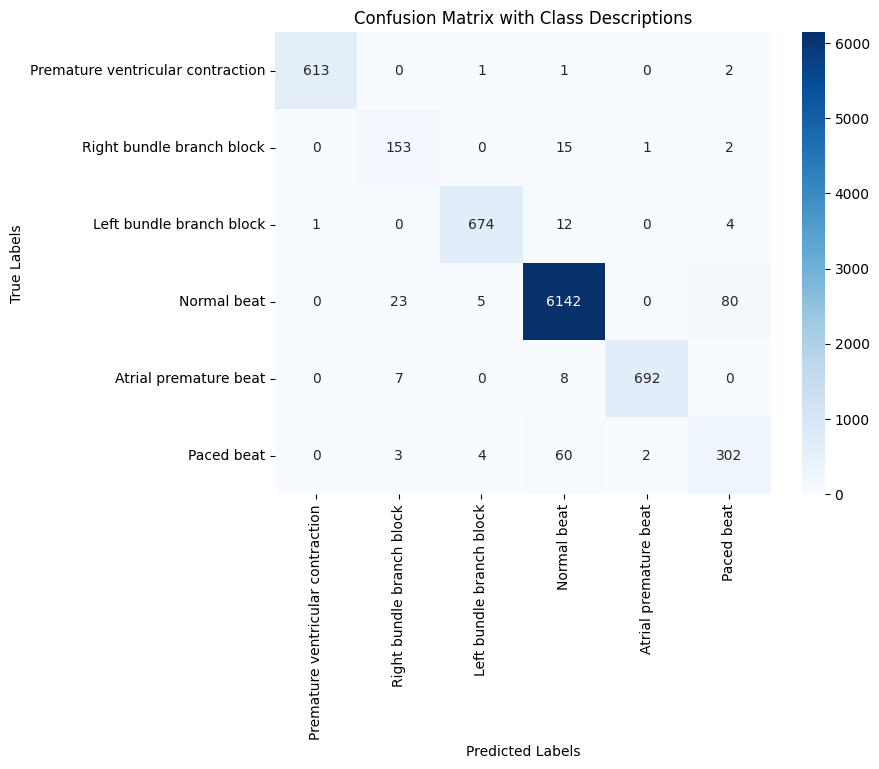

In [35]:
class_map = {
    0: 'V',
    1: 'R',
    2: 'L',
    3: 'N',
    4: 'A',
    5: '/'
}

# convert numeric labels to symbolic labels
true_labels_str = [class_map[label] for label in all_labels]
pred_labels_str = [class_map[label] for label in all_preds]

symbol_list = list(class_map.values())

# get class descriptions for display
display_labels = [get_symbol_description(sym) for sym in symbol_list]

# create confusion matrix
cm = confusion_matrix(true_labels_str, pred_labels_str, labels=symbol_list)

# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=display_labels, yticklabels=display_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix with Class Descriptions")
plt.show()

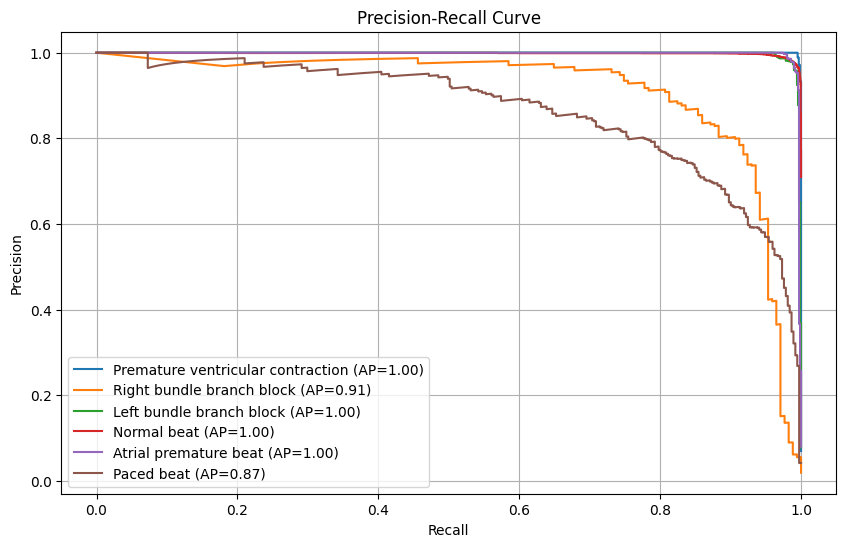

In [36]:
display_labels = [get_symbol_description(class_map[i]) for i in range(len(class_map))]

# Draw Precision-Recall curve
plt.figure(figsize=(10, 6))
for i, class_name in enumerate(display_labels):
    precision, recall, _ = precision_recall_curve(all_labels == i, all_probs[:, i])
    avg_prec = average_precision_score(all_labels == i, all_probs[:, i])
    plt.plot(recall, precision, label=f"{class_name} (AP={avg_prec:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()
plt.show()